# CreditCard Fraud Detection

## Import Libraries

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)


In [2]:
path = "fraud_detection_bank_dataset.csv"
df = pd.read_csv(path)
df.head()

,Unnamed: 0,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,...,col_103,col_104,col_105,col_106,col_107,col_108,col_109,col_110,col_111,targets
0,0,9,1354,0,18,0,1,7,9,0,...,0,0,0,1,1,0,0,0,49,1
1,1,0,239,0,1,0,1,0,0,0,...,0,1,0,0,0,0,0,0,55,1
2,2,0,260,0,4,0,3,6,0,0,...,0,0,0,1,1,0,0,0,56,1
3,3,17,682,0,1,0,0,8,17,0,...,0,1,0,1,1,0,0,0,65,1
4,4,1,540,0,2,0,1,7,1,0,...,0,0,0,1,1,0,0,0,175,1


In [4]:
df.shape

(20468, 114)

#### Checking for columns names, data types, missing values, duplicates and number of unique classes

In [5]:
def summary(df):
    summary_df = pd.DataFrame(df.dtypes, columns=['dtypes'])
    summary_df['Missing:np.nan'] = (df.isnull()).sum()
    summary_df['Missing:None'] = (df == "None").sum()
    summary_df['total'] = summary_df['Missing:np.nan'] + summary_df['Missing:None']
    summary_df['Percent'] = 100*summary_df['total']/len(df)
    summary_df['Duplicates'] = df.duplicated().sum()
    summary_df['Unique'] = df.nunique().values
    summary_df['Count'] = df.count().values
    return summary_df.sort_values(ascending = False, by = 'Percent')

summary(df).style.background_gradient(cmap='Blues')

,dtypes,Missing:np.nan,Missing:None,total,Percent,Duplicates,Unique,Count
Unnamed: 0,int64,0,0,0,0.000000,0,20468,20468
col_84,int64,0,0,0,0.000000,0,2,20468
col_82,int64,0,0,0,0.000000,0,2,20468
col_81,int64,0,0,0,0.000000,0,2,20468
col_80,int64,0,0,0,0.000000,0,2,20468
col_79,int64,0,0,0,0.000000,0,2,20468
col_78,int64,0,0,0,0.000000,0,2,20468
col_77,int64,0,0,0,0.000000,0,2,20468
col_76,int64,0,0,0,0.000000,0,2,20468
col_75,int64,0,0,0,0.000000,0,2,20468


## Data Preprocessing

In [6]:
# Identifying univariate columns
df_uniques = df.nunique()
univariate = list(df_uniques[df_uniques == 1].index)
univariate


['col_8',
 'col_9',
 'col_10',
 'col_11',
 'col_12',
 'col_18',
 'col_19',
 'col_20',
 'col_21',
 'col_35',
 'col_51',
 'col_52',
 'col_53',
 'col_70',
 'col_71']

In [7]:
df.drop(["Unnamed: 0"],axis =1, inplace = True)

In [8]:
## Droping univariate columns
df.drop(univariate,axis =1, inplace = True)

In [9]:
df.drop_duplicates(inplace=True)

In [10]:
df.shape

(20293, 98)

## Distribution of the target variable

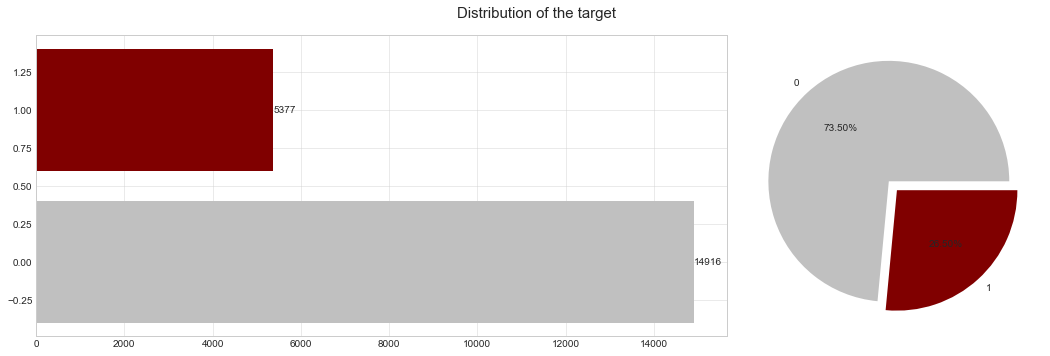

In [11]:
y = df['targets'].value_counts()
colors = ["Silver","maroon" ]
figure, axes = plt.subplots(1,2, figsize=(15,5), gridspec_kw={'width_ratios':[2,1]})


axes[0].barh(y=y.index, width=y.values, color=colors)
axes[0].set_xlabel('')
axes[0].set_ylabel('')
axes[0].grid(alpha=0.5)
for index, values in enumerate(y):
    axes[0].text(values+1, index, str(values), va='center')

axes[1].pie(y.values, labels=y.index, autopct='%.2f%%', explode=([0.05]*len(y.index)), colors=colors)

    

figure.suptitle('Distribution of the target', fontsize=15)
plt.tight_layout(pad=1)
plt.show()


## Data split

In [12]:
x = df.drop(["targets"], axis = 1)
y = df["targets"]

In [13]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=1)


print("number of test samples :",X_test.shape[0])
print("number of training samples:",X_train.shape[0])

number of test samples : 6088
number of training samples: 14205


In [14]:
## Features Importance (Mutual information Score)

In [15]:
discrete_features = X_train.dtypes == int

In [16]:
from sklearn.feature_selection import mutual_info_classif
def make_mi_scores(X_train,y_train,discrete_features):
    mi_scores = mutual_info_classif(X_train,y_train,discrete_features =discrete_features )
    mi_scores = pd.Series(mi_scores, name = "MI Scores", index = X_train.columns)
    mi_scores = mi_scores.sort_values(ascending = False)
    return mi_scores
mi_scores =  make_mi_scores(X_train,y_train,discrete_features) 
mi_scores

col_111    0.169306
col_5      0.148630
col_83     0.124679
col_3      0.088916
col_6      0.075948
             ...   
col_40     0.000000
col_27     0.000000
col_32     0.000000
col_46     0.000000
col_78     0.000000
Name: MI Scores, Length: 97, dtype: float64

## Features Selection

In [17]:
# Delete columns with 0.0 MI

In [18]:
def drop_uninformative(df, mi_scores):
    return df.loc[:, mi_scores > 0.0]
X_train = drop_uninformative(X_train, mi_scores)


In [19]:
X_test = drop_uninformative(X_test, mi_scores)


## Featutres Scaling

In [20]:
# X_train Scaling
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_scaled = scaler.fit_transform(X_train)
X_train = pd.DataFrame(df_scaled, columns = X_train.columns)

In [21]:
# X_valid Scaling
df_scaled = scaler.transform(X_test)
X_test = pd.DataFrame(df_scaled, columns = X_test.columns)
X_test.describe().round(3).T

,count,mean,std,min,25%,50%,75%,max
col_0,6088.0,-0.009,0.583,-0.144,-0.144,-0.144,-0.057,21.107
col_1,6088.0,-0.008,0.807,-0.393,-0.344,-0.266,-0.024,12.330
col_2,6088.0,-0.003,0.486,-0.051,-0.051,-0.051,-0.051,22.970
col_3,6088.0,0.002,0.946,-0.228,-0.228,-0.130,-0.033,34.818
col_5,6088.0,-0.022,0.761,-0.215,-0.215,-0.215,0.006,31.533
...,...,...,...,...,...,...,...,...
col_106,6088.0,-0.038,0.984,-0.680,-0.680,-0.680,1.470,1.470
col_107,6088.0,-0.038,0.970,-0.495,-0.495,-0.495,-0.495,2.019
col_109,6088.0,0.006,1.013,-0.228,-0.228,-0.228,-0.228,4.392
col_110,6088.0,0.013,1.013,-0.076,-0.076,-0.076,-0.076,35.964


## Modelling

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score,precision_score,recall_score,f1_score 
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc, precision_recall_curve
from sklearn.metrics import make_scorer
from sklearn.metrics import balanced_accuracy_score

### Helper functions

#### Ploting Confusion Matrix and Classification Report

In [23]:
from sklearn import metrics
def clf_plot(y_pred) :
    '''
    1) Ploting Confusion Matrix
    2) Plotting Classification Report'''
    cm = metrics.confusion_matrix(y_test, y_pred,normalize='true')
    cr = pd.DataFrame(metrics.classification_report(y_test, y_pred, digits=3, output_dict=True)).T
    cr.drop(columns='support', inplace=True)

    fig, ax = plt.subplots(1, 2, figsize=(15, 5))

    # Left: Confusion Matrix
    ax[0] = sns.heatmap(cm, annot=True, fmt='', cmap='YlGnBu', ax=ax[0])
    ax[0].set_xlabel('Predicted labels', fontsize=18)
    ax[0].set_ylabel('True labels', fontsize=18)
    ax[0].set_title('Confusion Matrix', fontsize=20)
    ax[0].xaxis.set_ticklabels([0,1])
    ax[0].yaxis.set_ticklabels([0,1])

    # Right: Classification Report
    ax[1] = sns.heatmap(cr, cmap='YlGnBu', annot=True, linecolor='white', linewidths=0.5, ax=ax[1])
    ax[1].xaxis.tick_top()
    ax[1].set_title('Classification Report', fontsize=20)
    plt.show()

#### Plotting ROC curve

In [24]:
from sklearn.metrics import roc_curve, auc

def roc(model,y_pred):
    # Predict the probabilities of the positive class
    y_pred = model.predict_proba(X_test)[:,1]
    y_pred.shape

    # Calculate the ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)

    # Calculate the AUC score
    auc_score = auc(fpr, tpr)
    x1=np.linspace(0,1,100)
    # Plot the ROC curve
    fig, axes = plt.subplots(1, 1, figsize=(5, 5), dpi=100)
    plt.plot(fpr, tpr, label="ROC curve (AUC = %0.2f)" % auc_score)
    plt.plot(x1,x1,label='baseline')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC curve for binary classification")
    plt.legend()
    plt.show()

## Random Forest Classifier

In [25]:
# RFC


from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(max_depth=22, n_estimators=100, random_state=1).fit(X_train, y_train)
y_val_pred1 = rfc.predict(X_test)

print(f'Precision: {precision_score(y_test, y_val_pred1)}')
print(f'Recall: {recall_score(y_test, y_val_pred1)}')
print(f'F1-Score: {f1_score(y_test, y_val_pred1)}')
print(f'AUROC: {roc_auc_score(y_test, y_val_pred1)}')


Precision: 0.9113333333333333
Recall: 0.8340451494813911
F1-Score: 0.8709780184772221
AUROC: 0.9020753955993154


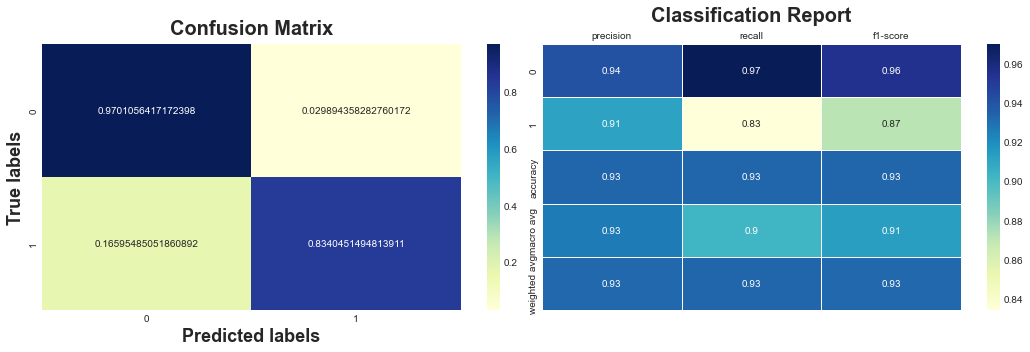

In [26]:
clf_plot(y_val_pred1)

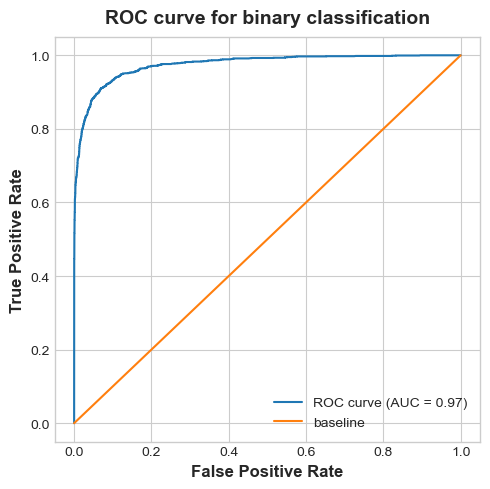

In [27]:
roc(rfc,y_val_pred1)

## KNeighbors Classifier

In [28]:
# KNN
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier().fit(X_train, y_train)
y_val_pred2 = knn.predict(X_test)

print(f'Precision: {precision_score(y_test, y_val_pred2)}')
print(f'Recall: {recall_score(y_test, y_val_pred2)}')
print(f'F1-Score: {f1_score(y_test, y_val_pred2)}')
print(f'AUROC: {roc_auc_score(y_test, y_val_pred2)}')

Precision: 0.8309948979591837
Recall: 0.7949969493593655
F1-Score: 0.8125974430932336
AUROC: 0.867716501202497


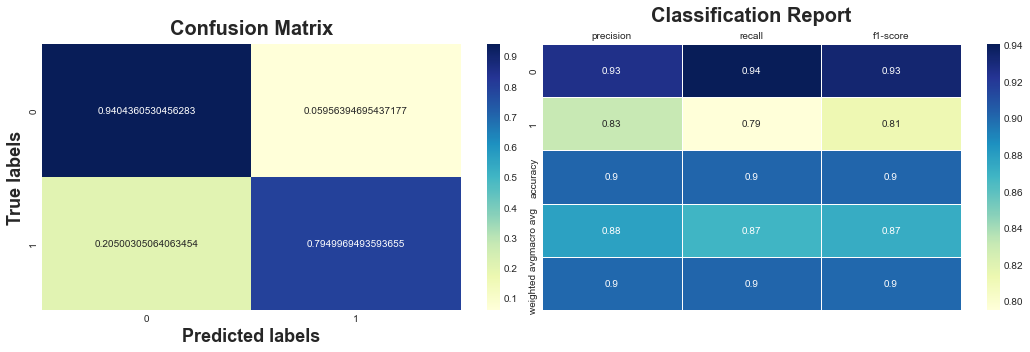

In [29]:
clf_plot(y_val_pred2)

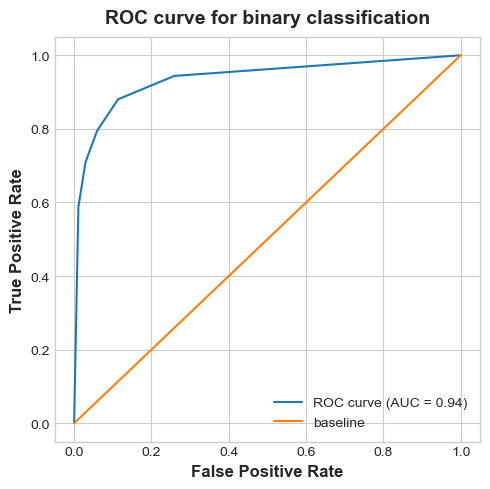

In [30]:
roc(knn,y_val_pred2)

## Logistic Regression

In [31]:
# Train Log Regression
lr = LogisticRegression(max_iter=400).fit(X_train, y_train)
y_val_pred3 = lr.predict(X_test)
## Classification Report for validation set



print(f'Precision: {precision_score(y_test, y_val_pred3)}')
print(f'Recall: {recall_score(y_test, y_val_pred3)}')
print(f'F1-Score: {f1_score(y_test, y_val_pred3)}')
print(f'AUROC: {roc_auc_score(y_test, y_val_pred3)}')

Precision: 0.893071000855432
Recall: 0.636973764490543
F1-Score: 0.7435897435897436
AUROC: 0.8044387815484857


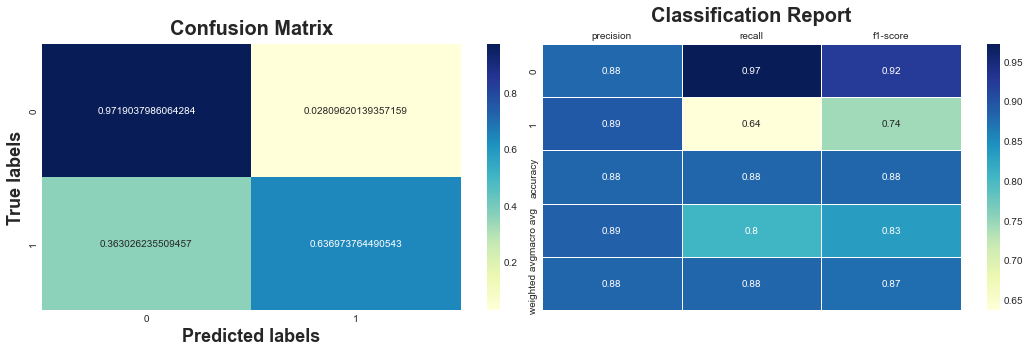

In [32]:
clf_plot(y_val_pred3)

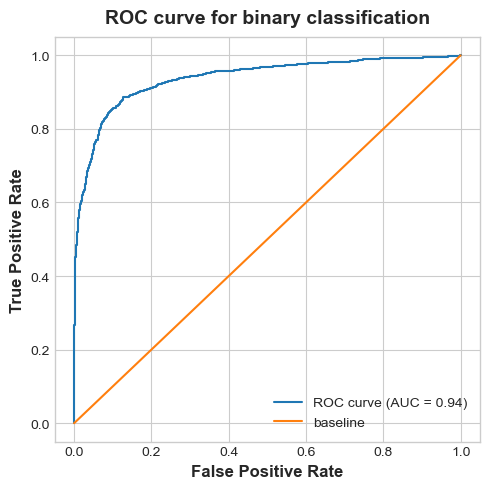

In [33]:
roc(lr,y_val_pred3)

## GaussianNB

In [34]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
model.fit(X_train, y_train)
y_val_pred4 =model.predict(X_test)

In [35]:
print(f'Precision: {precision_score(y_test, y_val_pred4)}')
print(f'Recall: {recall_score(y_test, y_val_pred4)}')
print(f'F1-Score: {f1_score(y_test, y_val_pred4)}')
print(f'AUROC: {roc_auc_score(y_test, y_val_pred4)}')

Precision: 0.7438752783964365
Recall: 0.6113483831604637
F1-Score: 0.6711319490957803
AUROC: 0.7669014336571032


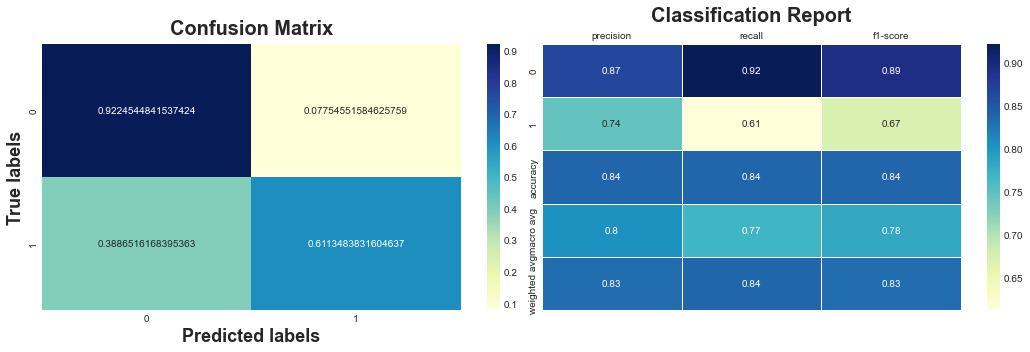

In [36]:
clf_plot(y_val_pred4)

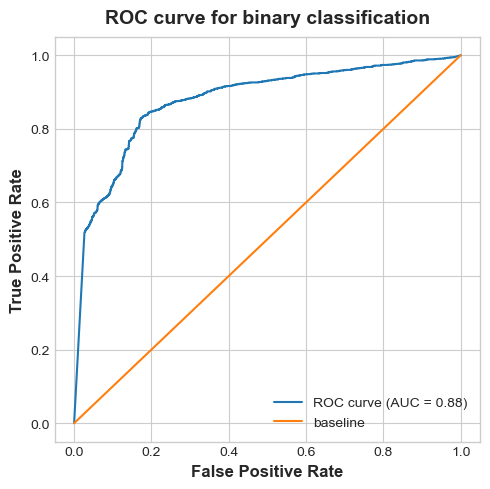

In [37]:
roc(model,y_val_pred4)

## Conclusion

### Comparing models performance

In [38]:
def measure_error(y_valid, y_val_pred, label):
    return pd.Series({"Accuracy": accuracy_score(y_valid, y_val_pred),
                     "Precision": precision_score(y_valid, y_val_pred),
                     "Recall": recall_score(y_valid, y_val_pred),
                     "F1": f1_score(y_valid, y_val_pred),
                     "AUROC": roc_auc_score(y_valid, y_val_pred)}, 
                     name = label)

In [39]:
RFC = pd.concat([measure_error(y_test, y_val_pred1,"RFC")],axis = 1)
KNN = pd.concat([measure_error(y_test, y_val_pred2,"KNN")],axis = 1)
Log_reg = pd.concat([measure_error(y_test, y_val_pred3,"Log_reg")],axis = 1)
GaussianNB = pd.concat([measure_error(y_test, y_val_pred4,"GaussianNB")],axis = 1)

In [41]:
compare_models =  pd.concat([RFC,KNN,Log_reg,GaussianNB],axis =1)
compare_models.style.background_gradient(cmap='Blues')

,RFC,KNN,Log_reg,GaussianNB
Accuracy,0.933476,0.901281,0.881735,0.838699
Precision,0.911333,0.830995,0.893071,0.743875
Recall,0.834045,0.794997,0.636974,0.611348
F1,0.870978,0.812597,0.743590,0.671132
AUROC,0.902075,0.867717,0.804439,0.766901


## Result :

### Based on the above output, best algorithm base on F1 Score is : Random Forest Classifier

---
# END
Thank you :)